Сначала подключаем нужные библиотеки, а также проверяем, что GPU работает

In [1]:
from __future__ import division
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import time, os, math, warnings
from matplotlib import pyplot

import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten, TimeDistributed, Reshape
from keras.layers import LSTM, GRU, SimpleRNN
from keras.utils import plot_model

In [2]:
# Set up some global variables
USE_GPU = True

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

# Constant to control how often we print when training models
print_every = 100

print('Using device: ', device)

Using device:  /device:GPU:0


### Pre-processing Functions

Из временого ряда создаём таймблок - блок данных, которые уже можно будет использовать в дальнейшем. Т.е. делим непрерывный ряд на блоки.

In [3]:
def create_timeblock(X, Y, look_back=1):
    dataX, dataY = [], []
    for i in range(len(X) - look_back):
        a = X[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(Y[i + look_back, :])
    print('# of data: ', len(dataY))
    return np.array(dataX), np.array(dataY)

### Plotting Functions

Много различных функций для отрисовки графиков

In [4]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def load_data(filename):
    """
    This function reads csv file from the given url and extracts time-series data of oil & water rate,
    pressure, and water cut.
    :param filename: the url of csv file (stored in GitHub)
    :return: t: vector of time; qo: matrix of oil rate in all wells; qo: matrix of water rate in all wells;
            and p: matrix of bottom hole pressure in all wells
    """
    df = pd.read_csv(filename)

    t = df.loc[:, ['TIME']] # Time in simulation: DAY
    t *= 24 # Converting time from DAY to HOUR
    qo = df.loc[:, ['WOPR:P1', 'WOPR:P2', 'WOPR:P3']]
    qw = df.loc[:, ['WWPR:P1', 'WWPR:P2', 'WWPR:P3']]
    p = df.loc[:, ['WBHP:P1', 'WBHP:P2', 'WBHP:P3']]
    wc = df.loc[:, ['WWCT:P1', 'WWCT:P2', 'WWCT:P3']]
    return t, qo, qw, wc, p

def plot_pressure(t, q_actual, q_pred, dev_fraction, test_fraction, well):
    """This function plots actual and predicted bottom hole pressure"""
    # Plotting pwf v time
    plt.figure()
    plt.plot(t, q_actual, 'k-', linewidth=3, label='Actual oil rate')

    # Training
    train_end = int((1 - dev_fraction - test_fraction) * q_pred.shape[0])
    plt.plot(t[0:train_end], q_pred[0:train_end],
                 'r-', markeredgecolor='red', label='Training Set', linewidth=3)
    
    # Dev
    dev_end = int((1 - test_fraction) * q_pred.shape[0])
    plt.plot(t[train_end:dev_end], q_pred[train_end:dev_end],
                 'y-', markeredgecolor='orange', label='Dev Set', linewidth=3)
    
    # Test
    plt.plot(t[dev_end:], q_pred[dev_end:],
                 'g-', markeredgecolor='green', label='Test Set', linewidth=3)    
    
    plt.xlabel("Time (hours)", fontsize=14)
    plt.ylabel("Bottom Hole Pressure (psi)", fontsize=14)
    plt.title("Bottom Hole Pressure Well "+str(well), y=1, fontsize=13)
    plt.legend(loc="best", prop=dict(size=14))
    plt.xlim(0, max(t))
    plt.ylim(0, max(max(q_actual), max(q_pred)) + 10)
    plt.grid(True)

def plot_pred_rate(t, q_actual, q_pred, dev_fraction, test_fraction, well):
    """This function plots actual and predicted bottom hole pressure"""
    # Plotting pwf v time
    plt.figure()
    plt.plot(t, q_actual, 'k-', linewidth=3, label='Actual oil rate')

    # Training
    train_end = int((1 - dev_fraction - test_fraction) * q_pred.shape[0])
    plt.plot(t[0:train_end], q_pred[0:train_end],
                 'r-', markeredgecolor='red', label='Training Set', linewidth=3)
    
    # Dev
    dev_end = int((1 - test_fraction) * q_pred.shape[0])
    plt.plot(t[train_end:dev_end], q_pred[train_end:dev_end],
                 'y-', markeredgecolor='orange', label='Dev Set', linewidth=3)
    
    # Test
    plt.plot(t[dev_end:], q_pred[dev_end:],
                 'g-', markeredgecolor='green', label='Test Set', linewidth=3)    
    
    plt.xlabel("Time (hours)", fontsize=14)
    plt.ylabel("Flow Rate (STB/d)", fontsize=14)
    plt.title("Flow Rate Well " +str(well), y=1, fontsize=13)
    plt.legend(loc="best", prop=dict(size=14))
    plt.xlim(0, max(t))
    plt.ylim(0, max(max(q_actual), max(q_pred)) + 10)
    plt.grid(True)

def plot_rates(t, q, wellname, color, label):
    """This function plots actual flow rates"""
    # Plotting Flow Rate v time
    plt.plot(t, q, color, linewidth=3, label=label)
    plt.xlabel("Time (hours)", fontsize=11)
    plt.ylabel("Flow Rate (STB/D)", fontsize=11)
    plt.title('Flow Rate Well ' + wellname, y=0.82, fontsize=9)
    plt.legend(loc=1, prop=dict(size=8))
    plt.xlim(0, max(t))
    plt.ylim(0, max(q) + 10)
    plt.grid(True)

def plot_pressure_rates(x, y, y_pred, labelname):
    """This function plots both pressure and actual flow rates"""
    plt.figure()
    if labelname=='Training Data':
        color='red'
    else:
        color='green'

    plt.subplot(411)
    plot_pressure(x['TIME'], y, y_pred, labelname, color)

    plt.subplot(412)
    plot_rates(x['TIME'], x['WWPR:P1'], wellname='A', color='blue', label='Water Rate')
    plot_rates(x['TIME'], x['WOPR:P1'], wellname='A', color='green', label='Oil Rate')
    plt.ylim(0, max(max(x['WWPR:P1'].values), max(x['WOPR:P1'].values)) + 10)

    plt.subplot(413)
    plot_rates(x['TIME'], x['WOPR:P2'],wellname='B',color='green', label='Oil Rate')
    plot_rates(x['TIME'], x['WWPR:P2'],wellname='B',color='blue', label='Water Rate')
    plt.ylim(0, max(max(x['WWPR:P2'].values), max(x['WOPR:P2'].values)) + 10)

    plt.subplot(414)
    plot_rates(x['TIME'], x['WOPR:P3'], wellname='C', color='green', label='Oil Rate')
    plot_rates(x['TIME'], x['WWPR:P3'], wellname='C', color='blue', label='Water Rate')
    plt.ylim(0, max(max(x['WWPR:P3'].values), max(x['WOPR:P3'].values)) + 10)

def plot_loss(history, title):
    plt.figure()
    plt.plot(history.history['loss'], label='Train Loss', linewidth=3)
    plt.plot(history.history['val_loss'], label='Dev Loss', linewidth=3)
    plt.legend()
    plt.grid()
    plt.xlabel("No of Epochs", fontsize=15)
    plt.ylabel("Loss", fontsize=15)
    plt.title('Loss - ' + title, fontsize=15)
    plt.xlim(0, len(history.history['loss']))
    plt.ylim(0, max(history.history['val_loss']))
    plt.show()

def plot_loss_comparison(histories):
    plt.figure()
    plt.plot(histories['Simple RNN'].history['val_loss'], linewidth=3, label='Simple RNN')
    plt.plot(histories['GRU'].history['val_loss'], linewidth=3, label='GRU')
    plt.plot(histories['LSTM'].history['val_loss'], linewidth=3, label='LSTM')
    plt.legend()
    plt.grid()
    plt.xlabel("No of Epochs", fontsize=15)
    plt.ylabel("Loss", fontsize=15)
    plt.title(' Dev Loss', fontsize=15)
    plt.xlim(0, len(histories['Simple RNN'].history['loss']))
    plt.ylim(0, 0.02)
    plt.show()


### Load Data

Загружаем данные в соответствующие переменные

In [5]:
t, qo, qw, wc, p = load_data('https://raw.githubusercontent.com/titaristanto/data-driven-production-problem/master/close_highWC_long.csv')


# Flow Rate Prediction

Приступаем к предсказанию расхода

### Pre-processing

Предобработка данных. Выключаем shuffle потому что это временной ряд и порядок данных имеет значение. 15% отдаём на тест, ещё 15% на валидацию.

In [6]:
# Group the input
X_raw = pd.concat([p['WBHP:P1'], p['WBHP:P2'], p['WBHP:P3']], axis=1, join='inner')
Y_raw = pd.concat([qo['WOPR:P1'], qo['WOPR:P2'], qo['WOPR:P3']], axis=1, join='inner')

# Split train-dev and test sets
test_fraction = 0.15
x_traindev_raw, x_test_raw, y_traindev_raw, y_test_raw = train_test_split(
    X_raw, Y_raw, test_size=test_fraction, shuffle=False
)

# Split train and dev sets
dev_fraction = 0.15  # of total dataset
x_train_raw, x_dev_raw, y_train_raw, y_dev_raw = train_test_split(
    x_traindev_raw, y_traindev_raw, test_size=dev_fraction / (1 - test_fraction), shuffle=False
)

# Data Scaling
scaler_x = MinMaxScaler()
x_train_norm = scaler_x.fit_transform(x_train_raw.to_numpy())
x_dev_norm = scaler_x.transform(x_dev_raw.to_numpy())
x_test_norm = scaler_x.transform(x_test_raw.to_numpy())

scaler_y = MinMaxScaler()
y_train_norm = scaler_y.fit_transform(y_train_raw.to_numpy())
y_dev_norm = scaler_y.transform(y_dev_raw.to_numpy())
y_test_norm = scaler_y.transform(y_test_raw.to_numpy())

# Create time blocks
x_train, y_train = create_timeblock(x_train_norm, y_train_norm, look_back=25)
x_dev, y_dev = create_timeblock(x_dev_norm, y_dev_norm, look_back=25)
x_test, y_test = create_timeblock(x_test_norm, y_test_norm, look_back=25)



# of data:  1235
# of data:  245
# of data:  246


Здесь начинаем запускать непосредственно модель. В зависимости от использования могут использоваться разные слои: GRU, LSTM и SimpleRNN. Количество слоёв GRU/LSTM/SimpleRNN равняется двум, в первом 512 нейронов, а во втором - 1024. Затем идёт слой TimeDistributed, а за ним dropout. Это нужно для регуляризации модели. В конце концов формирумем три выходных слоя с одним нейроном для каждого предсказываемого значения. В качестве метрик затем используется MAE и Accuracy. 

In [7]:
def run_model(x_train, y_train, x_dev, y_dev, epochs=500, batch_size=400, method='LSTM'):
    # Define the mapping of method names to RNN classes
    classifier = {
        'GRU': GRU,
        'LSTM': LSTM,
        'Simple RNN': SimpleRNN
    }

    # Input layer
    inputs = Input(shape=(x_train.shape[1], x_train.shape[2]))

    # Stacked RNN layers
    X = classifier[method](512, return_sequences=True)(inputs)
    X = classifier[method](1024, return_sequences=True)(X)

    # TimeDistributed dense layer followed by dropout
    X = TimeDistributed(Dense(256, activation='relu'))(X)
    X = Dropout(0.4)(X)

    # Output layers for each target
    out1 = Dense(1, activation='linear')(Flatten()(X))
    out2 = Dense(1, activation='linear')(Flatten()(X))
    out3 = Dense(1, activation='linear')(Flatten()(X))

    # Define the model with multiple outputs
    model = Model(inputs=inputs, outputs=[out1, out2, out3])

    # Compile the model
    model.compile(
        loss='mean_squared_error',
        optimizer='adam',
        metrics=['mae', 'accuracy']
    )

    # Train the model
    history = model.fit(
        x_train, [y_train[:, 0], y_train[:, 1], y_train[:, 2]],
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_dev, [y_dev[:, 0], y_dev[:, 1], y_dev[:, 2]]),
        verbose=1,
        shuffle=False
    )

    return model, history


Далее обучаем модель, используя GPU. Метод - LSTM.

In [8]:
model_LSTM, history_LSTM = run_model(x_train, y_train, x_dev, y_dev, epochs=300, batch_size=300, method='LSTM')

Epoch 1/300
5/5 [==============================] - 13s 332ms/step - loss: 0.3536 - dense_1_loss: 0.0897 - dense_2_loss: 0.1676 - dense_3_loss: 0.0963 - dense_1_mae: 0.2495 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.3360 - dense_2_accuracy: 0.0000e+00 - dense_3_mae: 0.2480 - dense_3_accuracy: 0.0000e+00 - val_loss: 0.1318 - val_dense_1_loss: 0.0936 - val_dense_2_loss: 0.0212 - val_dense_3_loss: 0.0170 - val_dense_1_mae: 0.2550 - val_dense_1_accuracy: 0.0000e+00 - val_dense_2_mae: 0.1086 - val_dense_2_accuracy: 0.0000e+00 - val_dense_3_mae: 0.1025 - val_dense_3_accuracy: 0.0000e+00
Epoch 2/300
5/5 [==============================] - 0s 70ms/step - loss: 0.1420 - dense_1_loss: 0.0556 - dense_2_loss: 0.0567 - dense_3_loss: 0.0298 - dense_1_mae: 0.1904 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.1832 - dense_2_accuracy: 0.0000e+00 - dense_3_mae: 0.1250 - dense_3_accuracy: 0.0000e+00 - val_loss: 0.0640 - val_dense_1_loss: 0.0200 - val_dense_2_loss: 0.0263 - val_dense_3_loss: 0.0177 -

Далее смотрим как модель предсказывает значения на всех наборах данных.

In [9]:
# Training
y_pred_train_pre = model_LSTM.predict(x_train)
y_pred_train_scaled = np.concatenate((y_pred_train_pre[0], y_pred_train_pre[1], y_pred_train_pre[2]), axis=1)
y_pred_train = scaler_y.inverse_transform(y_pred_train_scaled)
y_train_act = scaler_y.inverse_transform(y_train)

# Dev
y_pred_dev_pre = model_LSTM.predict(x_dev)
y_pred_dev_scaled = np.concatenate((y_pred_dev_pre[0], y_pred_dev_pre[1], y_pred_dev_pre[2]), axis=1)
y_pred_dev = scaler_y.inverse_transform(y_pred_dev_scaled)
y_dev_act = scaler_y.inverse_transform(y_dev)

# Test
y_pred_test_pre = model_LSTM.predict(x_test)
y_pred_test_scaled = np.concatenate((y_pred_test_pre[0], y_pred_test_pre[1], y_pred_test_pre[2]), axis=1)
y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled)
y_test_act = scaler_y.inverse_transform(y_test)

# Train-Dev-Test
y_act = np.concatenate([y_train_act, y_dev_act, y_test_act])
y_pred = np.concatenate([y_pred_train, y_pred_dev, y_pred_test])

8/8 [==============================] - 0s 7ms/step


Далее выводим график изменения значений Loss функций по ходу обучения, для контроля переобучения. Также выводим значения MSE и R2 (коэффициент детерминации).

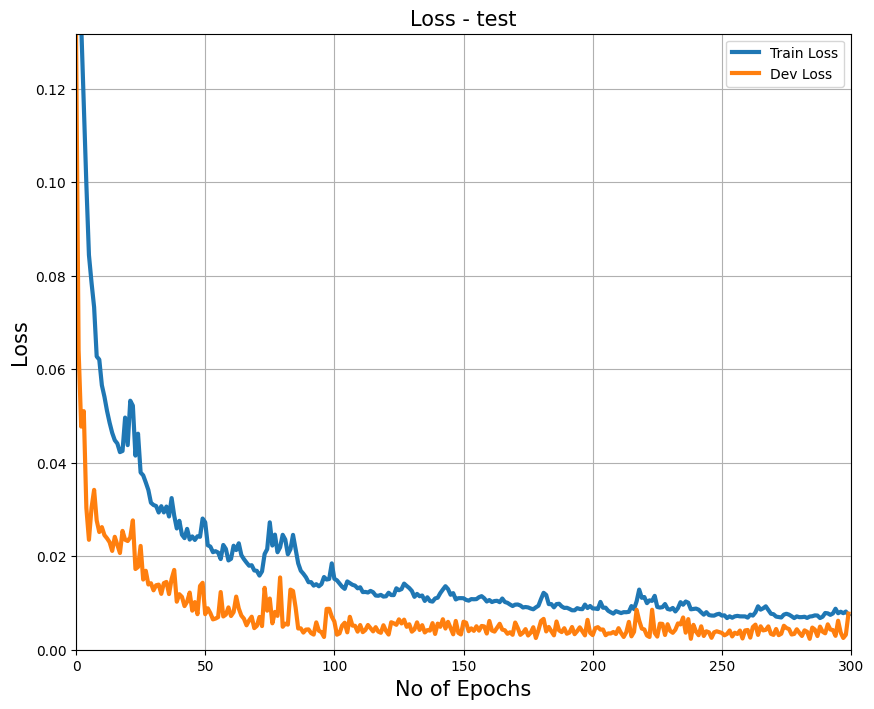

Training Set Score: 0.9210
Dev Set Score: 0.5777
Test Set Score: -7.1886
Training Set MSE: 2249.1487
Dev Set MSE: 2607.3313
Test Set MSE: 3222.8486


In [10]:
plot_loss(history_LSTM, title='test')
#plt.savefig('loss_LSTM_512_1024_lb25_well_' + str(i))
train_mse, train_acc = mean_squared_error(y_train_act, y_pred_train), r2_score(y_train_act, y_pred_train)
dev_mse, dev_acc = mean_squared_error(y_dev_act, y_pred_dev), r2_score(y_dev_act, y_pred_dev)
test_mse, test_acc = mean_squared_error(y_test_act, y_pred_test), r2_score(y_test_act, y_pred_test)

print('Training Set Score: %1.4f' % train_acc)
print('Dev Set Score: %1.4f' % dev_acc)
print('Test Set Score: %1.4f' % test_acc)

print('Training Set MSE: %1.4f' % train_mse)
print('Dev Set MSE: %1.4f' % dev_mse)
print('Test Set MSE: %1.4f' % test_mse)

Видно, что какого-то значительного переобучения нет. Модель на обучающем наборе данных набрала метрику R2 равной 0.92, что является хорошим результатом, но на Dev сете это значение уже упало до 0.57, а на test сете имеем отрицательное значение, что говорит о том, что подставляя среднее значение мы оказались бы ближе к реальности, чем с нашей моделью. Выведем как модель предсказывает данные на график:

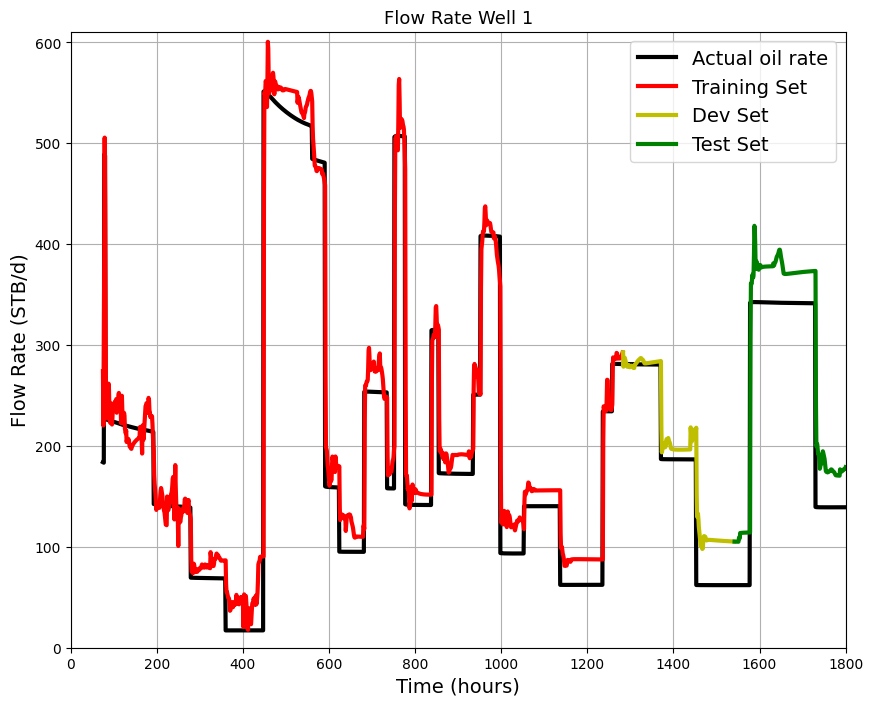

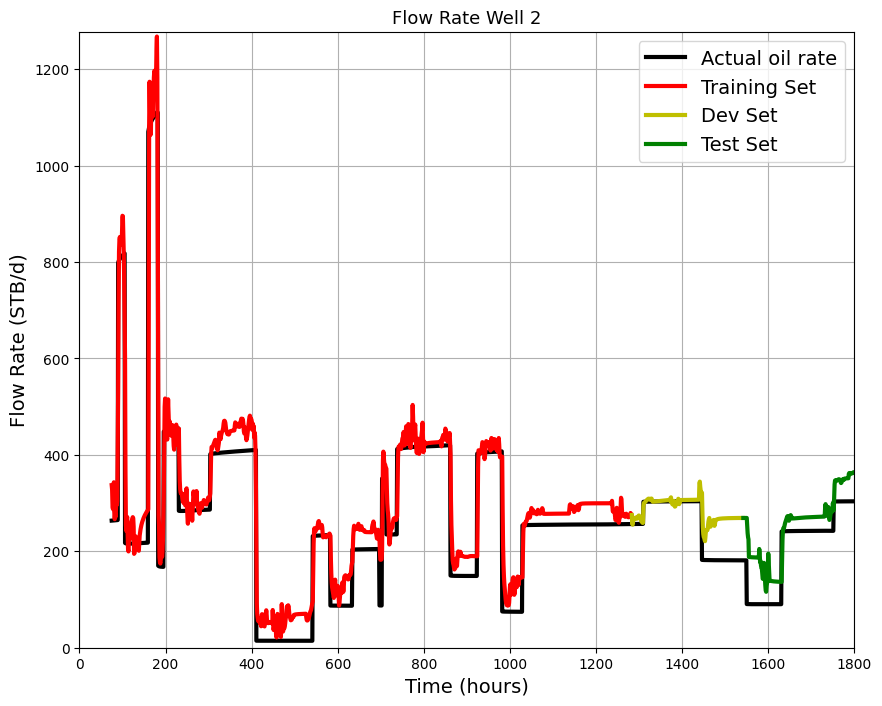

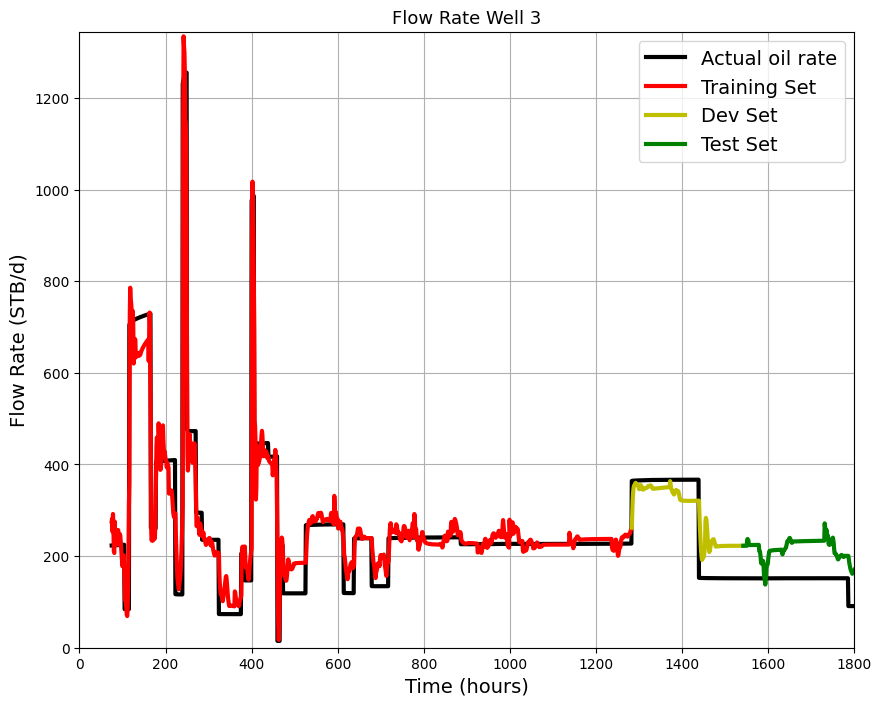

In [12]:
for i in range(y_act.shape[1]):
    plot_pred_rate(t[-len(y_act):].to_numpy(),
                   y_act[:, i], y_pred[:, i], dev_fraction=dev_fraction, test_fraction=test_fraction, well=i+1)
    plt.savefig('traindev_LSTM_512_1024_lb25_well_' + str(i))

Видно, что модель в целом уловила паттерн, но на валидационных и сетах имеет смещение. Проделаем то же самое с другим методом, GRU.

GRU

Epoch 1/300
5/5 [==============================] - 5s 283ms/step - loss: 0.3678 - dense_9_loss: 0.1149 - dense_10_loss: 0.1555 - dense_11_loss: 0.0973 - dense_9_mae: 0.2579 - dense_9_accuracy: 0.0000e+00 - dense_10_mae: 0.3252 - dense_10_accuracy: 0.0000e+00 - dense_11_mae: 0.2535 - dense_11_accuracy: 0.0000e+00 - val_loss: 0.1200 - val_dense_9_loss: 0.0758 - val_dense_10_loss: 0.0200 - val_dense_11_loss: 0.0241 - val_dense_9_mae: 0.2197 - val_dense_9_accuracy: 0.0000e+00 - val_dense_10_mae: 0.1016 - val_dense_10_accuracy: 0.0000e+00 - val_dense_11_mae: 0.1116 - val_dense_11_accuracy: 0.0000e+00
Epoch 2/300
5/5 [==============================] - 0s 58ms/step - loss: 0.1527 - dense_9_loss: 0.0617 - dense_10_loss: 0.0534 - dense_11_loss: 0.0376 - dense_9_mae: 0.2048 - dense_9_accuracy: 0.0000e+00 - dense_10_mae: 0.1743 - dense_10_accuracy: 0.0000e+00 - dense_11_mae: 0.1483 - dense_11_accuracy: 0.0000e+00 - val_loss: 0.0671 - val_dense_9_loss: 0.0155 - val_dense_10_loss: 0.0233 - val_dens

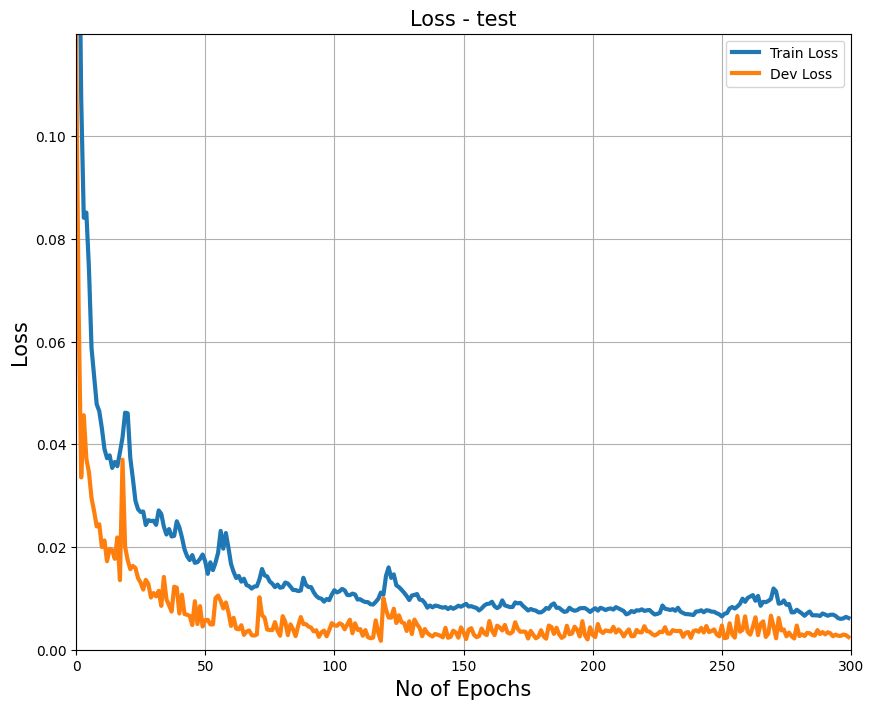

Training Set Score: 0.9443
Dev Set Score: 0.8859
Test Set Score: -1.0135
Training Set MSE: 1546.7298
Dev Set MSE: 789.9507
Test Set MSE: 946.3902


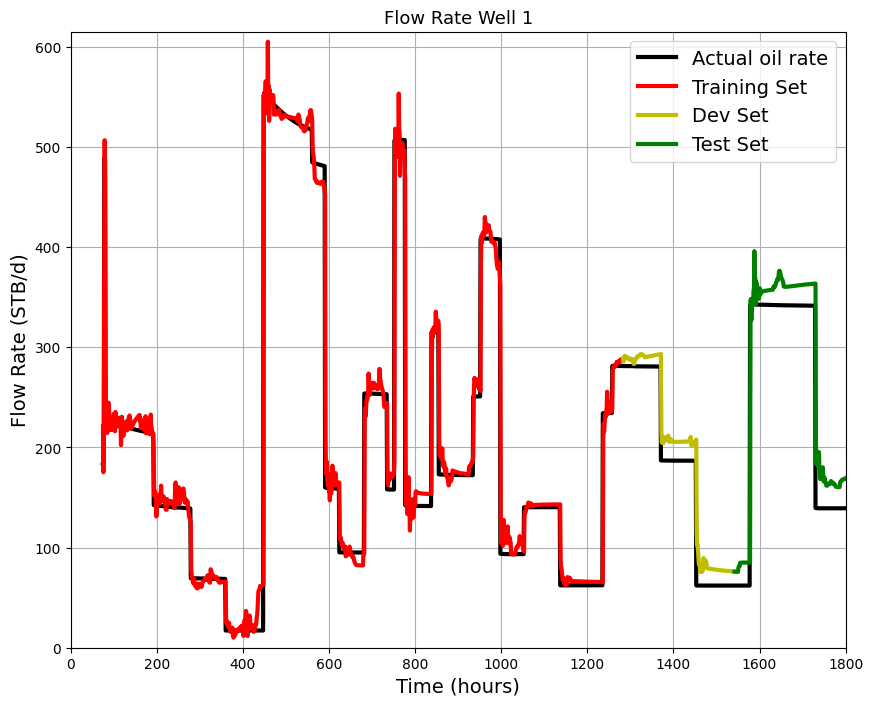

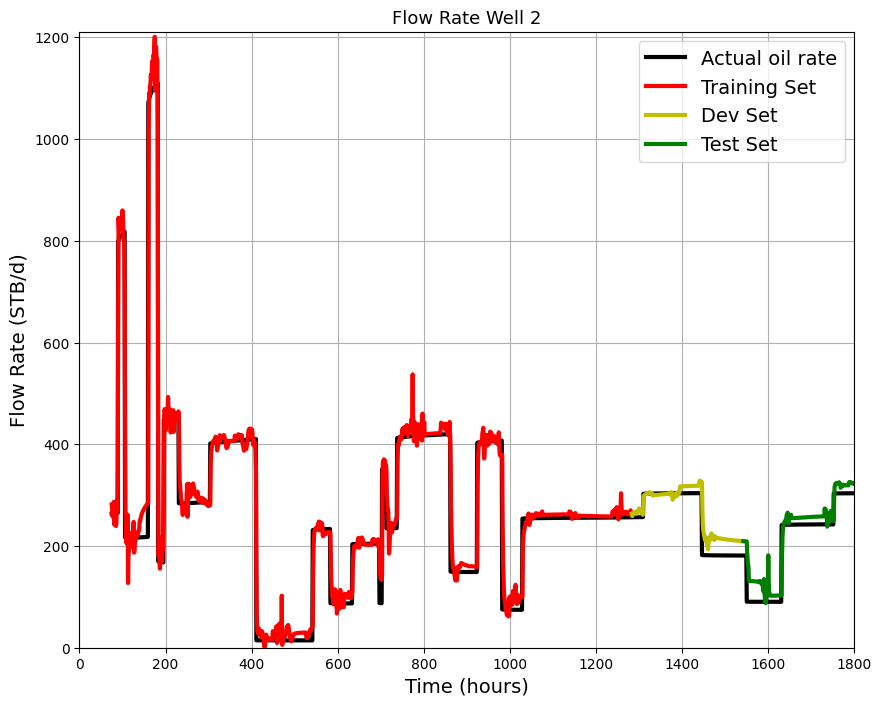

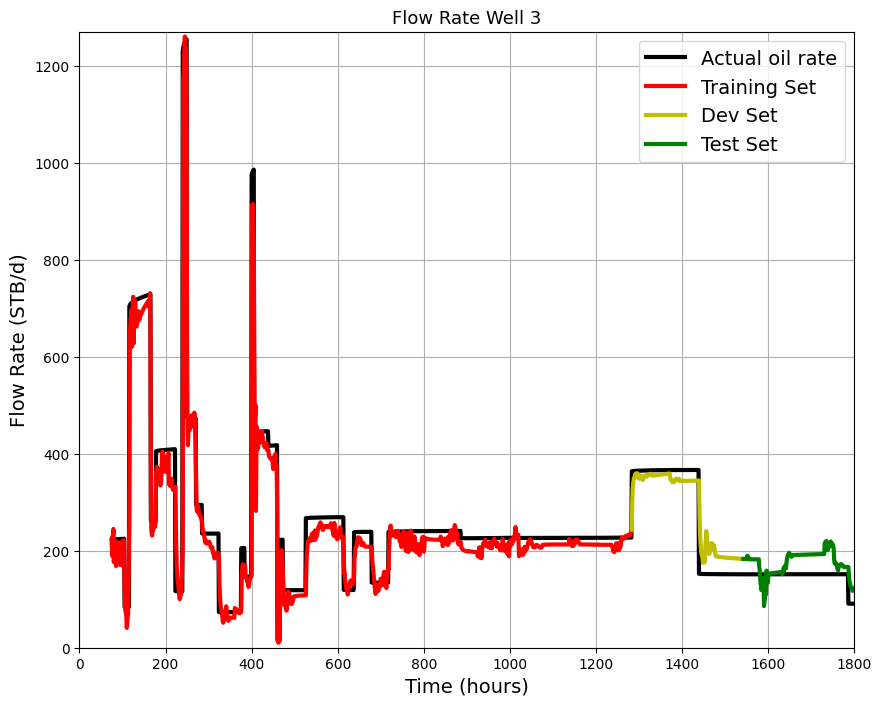

In [14]:
model_GRU, history_GRU = run_model(x_train, y_train, x_dev, y_dev, epochs=300, batch_size=300, method='GRU')

# Training
y_pred_train_pre = model_GRU.predict(x_train)
y_pred_train_scaled = np.concatenate((y_pred_train_pre[0], y_pred_train_pre[1], y_pred_train_pre[2]), axis=1)
y_pred_train = scaler_y.inverse_transform(y_pred_train_scaled)
y_train_act = scaler_y.inverse_transform(y_train)

# Dev
y_pred_dev_pre = model_GRU.predict(x_dev)
y_pred_dev_scaled = np.concatenate((y_pred_dev_pre[0], y_pred_dev_pre[1], y_pred_dev_pre[2]), axis=1)
y_pred_dev = scaler_y.inverse_transform(y_pred_dev_scaled)
y_dev_act = scaler_y.inverse_transform(y_dev)

# Test
y_pred_test_pre = model_GRU.predict(x_test)
y_pred_test_scaled = np.concatenate((y_pred_test_pre[0], y_pred_test_pre[1], y_pred_test_pre[2]), axis=1)
y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled)
y_test_act = scaler_y.inverse_transform(y_test)

# Train-Dev-Test
y_act = np.concatenate([y_train_act, y_dev_act, y_test_act])
y_pred = np.concatenate([y_pred_train, y_pred_dev, y_pred_test])

plot_loss(history_GRU, title='test')
#plt.savefig('loss_LSTM_512_1024_lb25_well_' + str(i))
train_mse, train_acc = mean_squared_error(y_train_act, y_pred_train), r2_score(y_train_act, y_pred_train)
dev_mse, dev_acc = mean_squared_error(y_dev_act, y_pred_dev), r2_score(y_dev_act, y_pred_dev)
test_mse, test_acc = mean_squared_error(y_test_act, y_pred_test), r2_score(y_test_act, y_pred_test)

print('Training Set Score: %1.4f' % train_acc)
print('Dev Set Score: %1.4f' % dev_acc)
print('Test Set Score: %1.4f' % test_acc)

print('Training Set MSE: %1.4f' % train_mse)
print('Dev Set MSE: %1.4f' % dev_mse)
print('Test Set MSE: %1.4f' % test_mse)

for i in range(y_act.shape[1]):
    plot_pred_rate(t[-len(y_act):].to_numpy(),
                   y_act[:, i], y_pred[:, i], dev_fraction=dev_fraction, test_fraction=test_fraction, well=i+1)
    plt.savefig('traindev_LSTM_512_1024_lb25_well_' + str(i))

Данный метод хорошо себя показывает на train и dev сетах, но в test опять случается коллапс, R2 равен -1, что значительно хуже, чем просто среднее значение.


Simple RNN

Epoch 1/300
5/5 [==============================] - 3s 209ms/step - loss: 24.7930 - dense_13_loss: 9.0964 - dense_14_loss: 9.0702 - dense_15_loss: 6.6263 - dense_13_mae: 2.3715 - dense_13_accuracy: 0.0000e+00 - dense_14_mae: 2.0476 - dense_14_accuracy: 0.0000e+00 - dense_15_mae: 1.8137 - dense_15_accuracy: 0.0000e+00 - val_loss: 2.6293 - val_dense_13_loss: 1.6765 - val_dense_14_loss: 0.1401 - val_dense_15_loss: 0.8127 - val_dense_13_mae: 1.2892 - val_dense_13_accuracy: 0.0000e+00 - val_dense_14_mae: 0.3727 - val_dense_14_accuracy: 0.0000e+00 - val_dense_15_mae: 0.8951 - val_dense_15_accuracy: 0.0000e+00
Epoch 2/300
5/5 [==============================] - 0s 87ms/step - loss: 2.1422 - dense_13_loss: 1.2480 - dense_14_loss: 0.2976 - dense_15_loss: 0.5966 - dense_13_mae: 0.9352 - dense_13_accuracy: 0.0000e+00 - dense_14_mae: 0.4379 - dense_14_accuracy: 0.0000e+00 - dense_15_mae: 0.6398 - dense_15_accuracy: 8.0972e-04 - val_loss: 3.5998 - val_dense_13_loss: 1.7932 - val_dense_14_loss: 1.5263

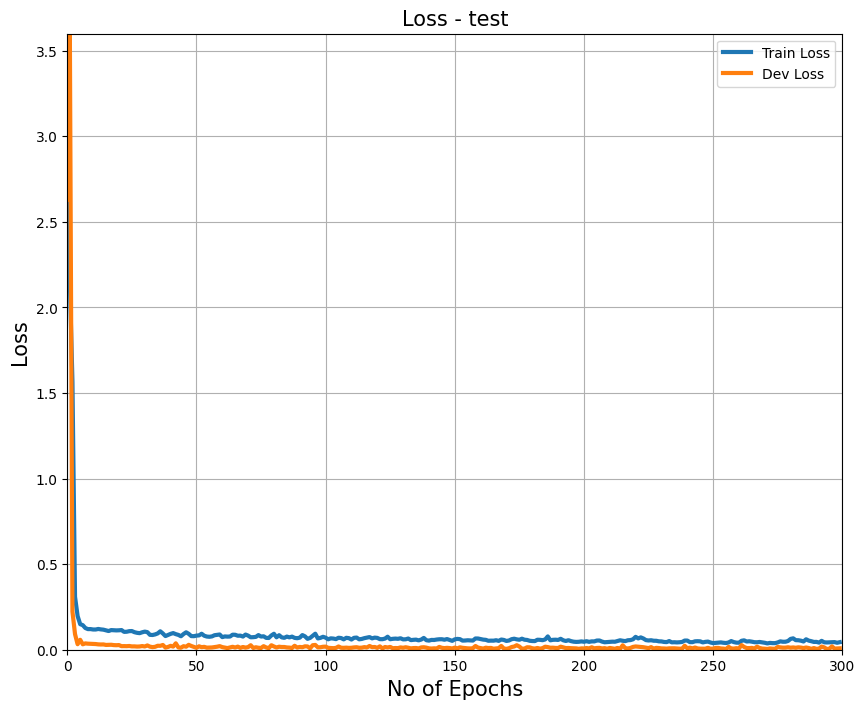

Training Set Score: 0.5943
Dev Set Score: 0.6185
Test Set Score: -7.7244
Training Set MSE: 11403.2982
Dev Set MSE: 3094.0642
Test Set MSE: 3716.9033


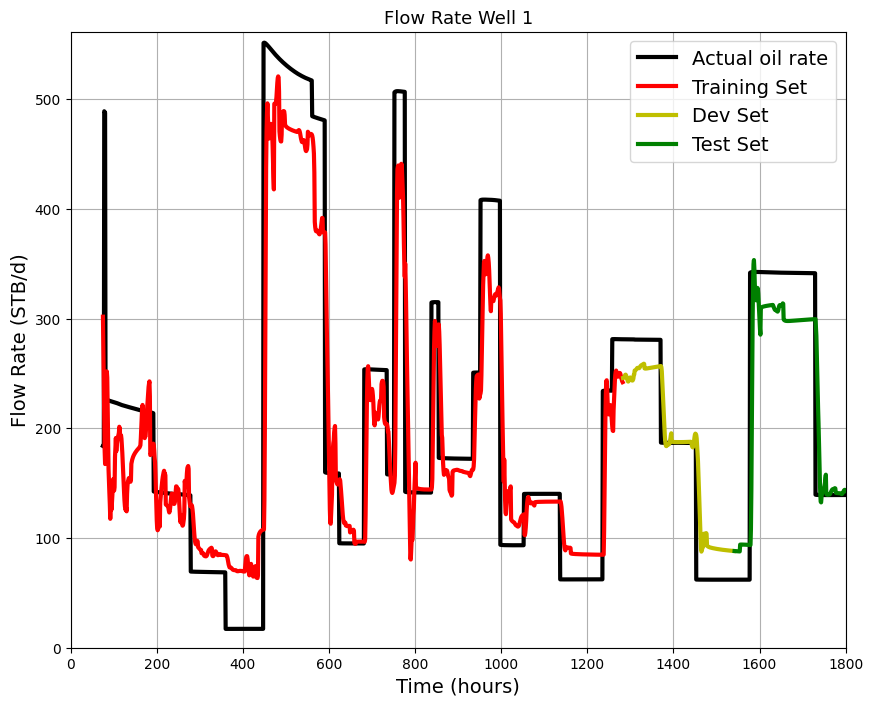

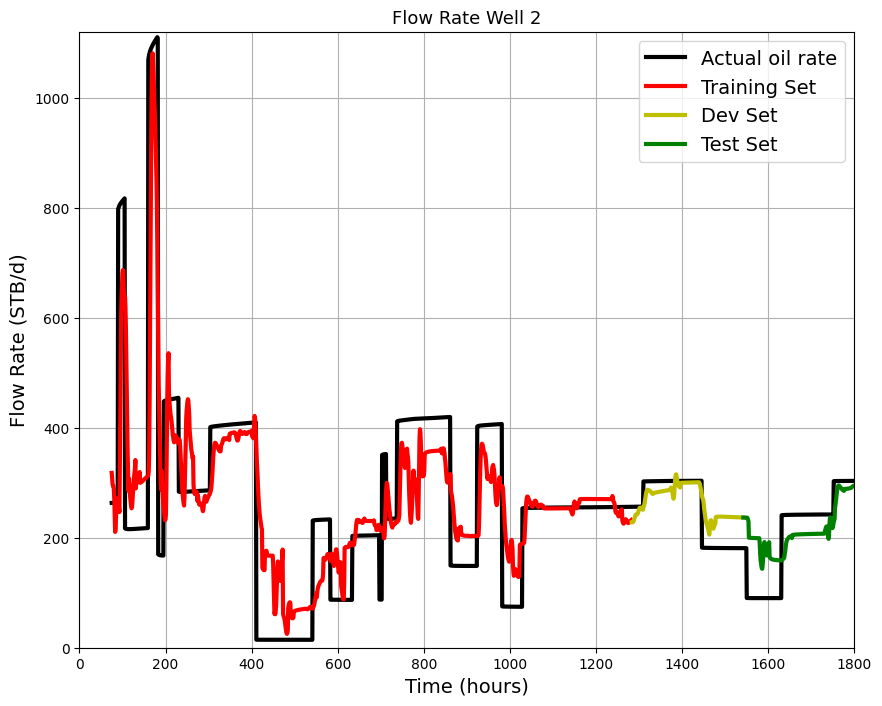

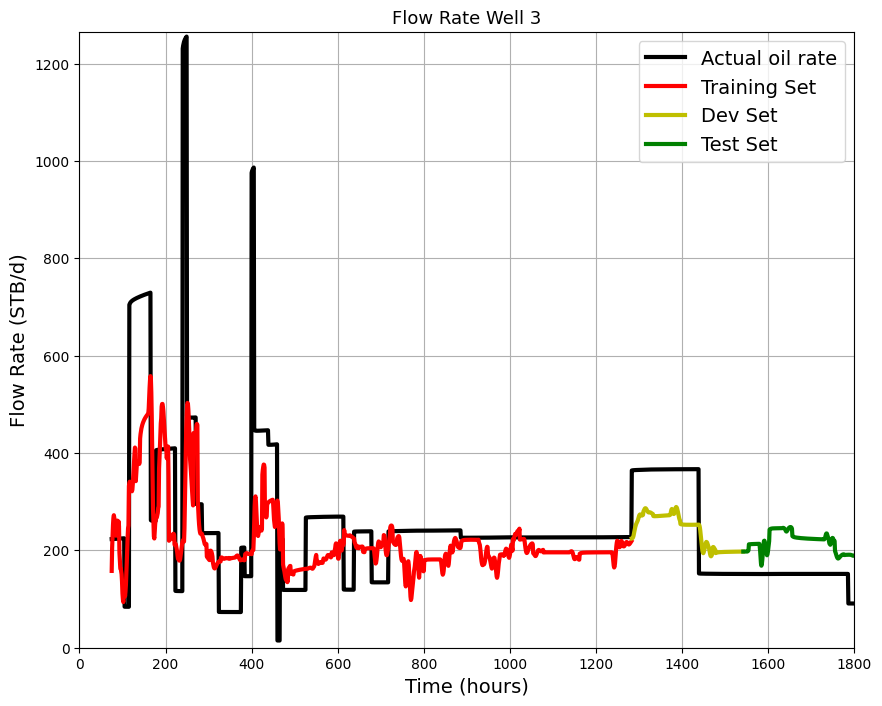

In [15]:
import time
start_time = time.time()
model_RNN, history_RNN = run_model(x_train, y_train, x_dev, y_dev, epochs=300, batch_size=300, method='Simple RNN')
# Measure running time
print("Completed in %s seconds" % (time.time() - start_time))

# Training
y_pred_train_pre = model_RNN.predict(x_train)
y_pred_train_scaled = np.concatenate((y_pred_train_pre[0], y_pred_train_pre[1], y_pred_train_pre[2]), axis=1)
y_pred_train = scaler_y.inverse_transform(y_pred_train_scaled)
y_train_act = scaler_y.inverse_transform(y_train)

# Dev
y_pred_dev_pre = model_RNN.predict(x_dev)
y_pred_dev_scaled = np.concatenate((y_pred_dev_pre[0], y_pred_dev_pre[1], y_pred_dev_pre[2]), axis=1)
y_pred_dev = scaler_y.inverse_transform(y_pred_dev_scaled)
y_dev_act = scaler_y.inverse_transform(y_dev)

# Test
y_pred_test_pre = model_RNN.predict(x_test)
y_pred_test_scaled = np.concatenate((y_pred_test_pre[0], y_pred_test_pre[1], y_pred_test_pre[2]), axis=1)
y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled)
y_test_act = scaler_y.inverse_transform(y_test)

# Train-Dev-Test
y_act = np.concatenate([y_train_act, y_dev_act, y_test_act])
y_pred = np.concatenate([y_pred_train, y_pred_dev, y_pred_test])

plot_loss(history_RNN, title='test')
#plt.savefig('loss_LSTM_512_1024_lb25_well_' + str(i))
train_mse, train_acc = mean_squared_error(y_train_act, y_pred_train), r2_score(y_train_act, y_pred_train)
dev_mse, dev_acc = mean_squared_error(y_dev_act, y_pred_dev), r2_score(y_dev_act, y_pred_dev)
test_mse, test_acc = mean_squared_error(y_test_act, y_pred_test), r2_score(y_test_act, y_pred_test)

print('Training Set Score: %1.4f' % train_acc)
print('Dev Set Score: %1.4f' % dev_acc)
print('Test Set Score: %1.4f' % test_acc)

print('Training Set MSE: %1.4f' % train_mse)
print('Dev Set MSE: %1.4f' % dev_mse)
print('Test Set MSE: %1.4f' % test_mse)

for i in range(y_act.shape[1]):
    plot_pred_rate(t[-len(y_act):].to_numpy(),
                   y_act[:, i], y_pred[:, i], dev_fraction=dev_fraction, test_fraction=test_fraction, well=i+1)
    plt.savefig('traindev_LSTM_512_1024_lb25_well_' + str(i))

Как видно, здесь мы тоже имеем крайне низкое значение R2 score в test сете. /

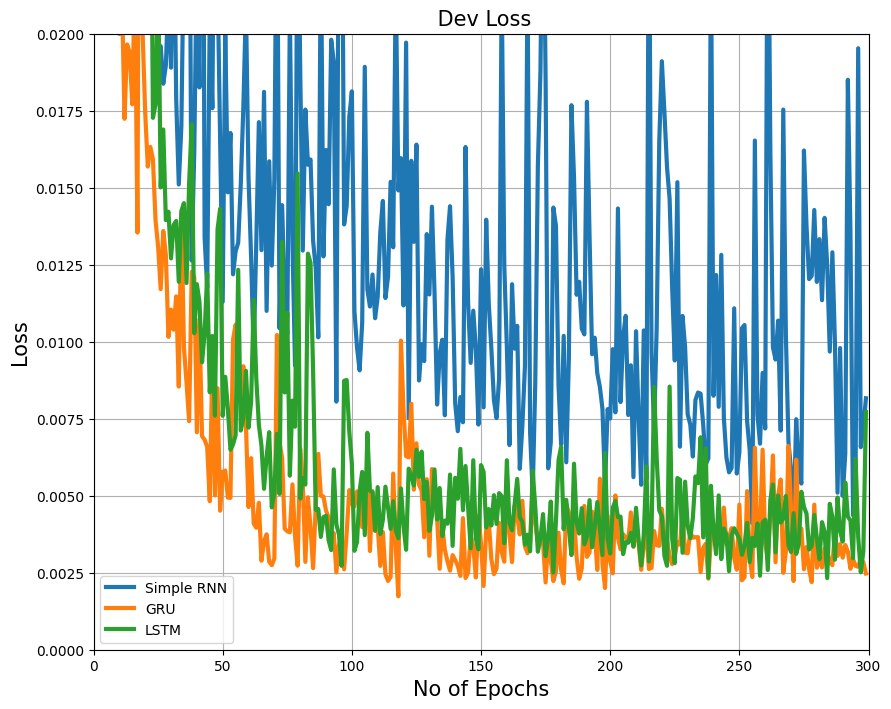

In [16]:
histories = {'Simple RNN': history_RNN,
            'GRU': history_GRU,
            'LSTM': history_LSTM}
plot_loss_comparison(histories)

По данному графику можно сказать, что модели GRU и LSTM успевают обучиться за 300 эпох, поскольку значение loss функции перестаёт разительно меняться. По SmipleRNN сказать так сложнее, из-за большой дисперсии значений. В целом модели получились не очень удачными: все из них хорошо себя показывают на обучающем наборе данных, но как только стоит выйти за этот раздел (test сет), так идёт большая просадка по качеству и все они становятся хуже обычного среднего значения. 